
# Simulazione di politiche di similarity caching

In [1]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
from PromptDatasetManager import PromptDatasetManager
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=None # Limita per testare velocemente
)
print(f"Colonne disponibili: {list(manager.df.columns)}")

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp']


## Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used) e TTL (Time To Live) per la gestione della cache.

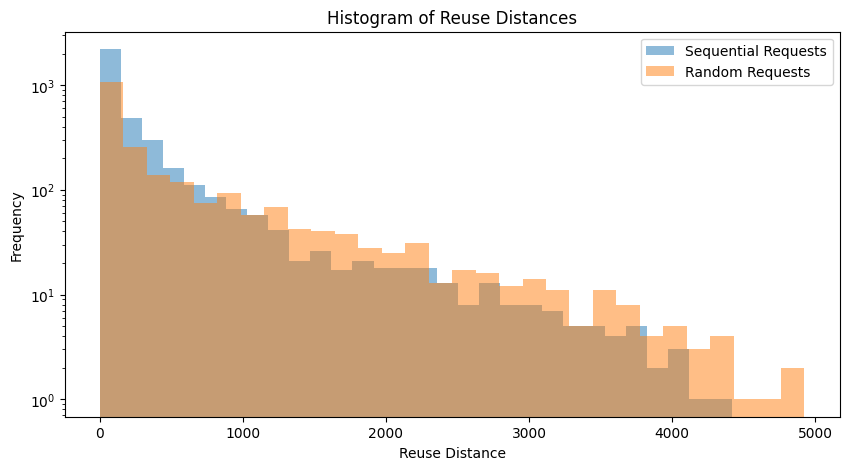

In [3]:

def compute_reuse_dist(requests: List[str], embs: List[np.ndarray], threshold: float = 0.5) -> List[int]:
    last = []
    deltas = []
    for i, emb in enumerate(embs):
        for j in reversed(range(i)):
            dist = np.linalg.norm(emb - embs[j])
            if dist < threshold:
                deltas.append(i - j)
                break  # usa solo la prima occorrenza simile andando indietro
    return deltas


seq_requests = manager.sample_prompts(num_prompts=5000, random_order=False)
rand_requests = manager.sample_prompts(num_prompts=5000, random_order=True)

reuse_seq = compute_reuse_dist(
    [p for p, _ in seq_requests],
    [e for _, e in seq_requests],
    threshold=0.8
)

reuse_rand = compute_reuse_dist(
    [p for p, _ in rand_requests],
    [e for _, e in rand_requests],
    threshold=0.8
)

# Plot histogram of reuse distances (log scale)
plt.figure(figsize=(10, 5))
plt.hist(reuse_seq, bins=30, alpha=0.5, label='Sequential Requests', log=True)
plt.hist(reuse_rand, bins=30, alpha=0.5, label='Random Requests', log=True)
plt.title('Histogram of Reuse Distances')
plt.xlabel('Reuse Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [4]:
import Dashboard as ds
from CachePolicy import LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache, TwoLRUCache

In [5]:

caching_policies = [LRUCache, LFUCache, TTLCache, RNDLRUCache, RNDTTLCache, TwoLRUCache]

dim = manager.emb_matrix.shape[1]
dashboard = ds.get_dashboard(manager, caching_policies, num_requests=5000, dim=dim)
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'acd1c39d-b7ef-4b0a-99aa-3dafe63a892a': {'version…

### Chaching test

In [6]:
def faiss_search_similarity(
    index: faiss.IndexFlatIP,
    query: np.ndarray,
    topk: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Esegue una ricerca di similarità usando FAISS.
    Ritorna le distanze e gli indici dei top-k risultati.
    La ricerca la fa su tutto il dataset indicizzato.
    - index: istanza di faiss.IndexFlatIP indicizzata
    - query: vettore di query (1D o 2D con una riga)
    - topk: numero di risultati da restituire
    """
    query = query.reshape(1, -1).astype(np.float32)
    distances, indices = index.search(query, topk)
    return distances[0], indices[0]

# Create FAISS index from the embedding matrix
dim = manager.emb_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(manager.emb_matrix.astype(np.float32))

# Stampa le prime 10 similarità per un prompt casuale
prompt, emb = manager.sample_prompts(num_prompts=1, random_order=True)[0]
print(f"Prompt: {prompt}")
distances, indices = faiss_search_similarity(index, emb, topk=10)
print("Top-10 Similarities:")
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if idx == -1:  # -1 indica che non ci sono risultati
        continue
    print(f"{i+1}: {manager.prompts_arr[idx]} (Similarity: {dist:.4f})")
print("Total prompts in index:", len(manager.prompts_arr))


Prompt: the female arcanist and the male artificer by zacharias aagaard and albert bierstadt and gerald brom and zdzisław beksinski and james gilleard and wayne barlowe and marc simonetti, beautiful, robes, highly detailed, hyperrealistic, intricate, energy, electricity, blue flame, low light, green crystal, high contrast 
Top-10 Similarities:
1: the female arcanist and the male artificer by zacharias aagaard and albert bierstadt and gerald brom and zdzisław beksinski and james gilleard and wayne barlowe and marc simonetti, beautiful, robes, highly detailed, hyperrealistic, intricate, energy, electricity, blue flame, low light, green crystal, high contrast  (Similarity: 1.0000)
2: the female arcanist and the male artificer by zacharias aagaard and albert bierstadt and gerald brom and zdzisław beksinski and james gilleard and wayne barlowe and jean delville, beautiful, robes, highly detailed, hyperrealistic, intricate, energy, electricity, blue flame, low light, green crystal, high cont


Benchmarking FAISS_FLAT backend...
FAISS_FLAT | Cache: 10 | Time/query: 0.000010s
FAISS_FLAT | Cache: 1000 | Time/query: 0.000041s
FAISS_FLAT | Cache: 5000 | Time/query: 0.000173s
FAISS_FLAT | Cache: 25000 | Time/query: 0.000900s
FAISS_FLAT | Cache: 75000 | Time/query: 0.002749s
FAISS_FLAT | Cache: 100000 | Time/query: 0.003450s

Benchmarking LINEAR backend...
LINEAR | Cache: 10 | Time/query: 0.000018s
LINEAR | Cache: 1000 | Time/query: 0.000308s
LINEAR | Cache: 5000 | Time/query: 0.001481s
LINEAR | Cache: 25000 | Time/query: 0.007418s
LINEAR | Cache: 75000 | Time/query: 0.022592s
LINEAR | Cache: 100000 | Time/query: 0.029816s


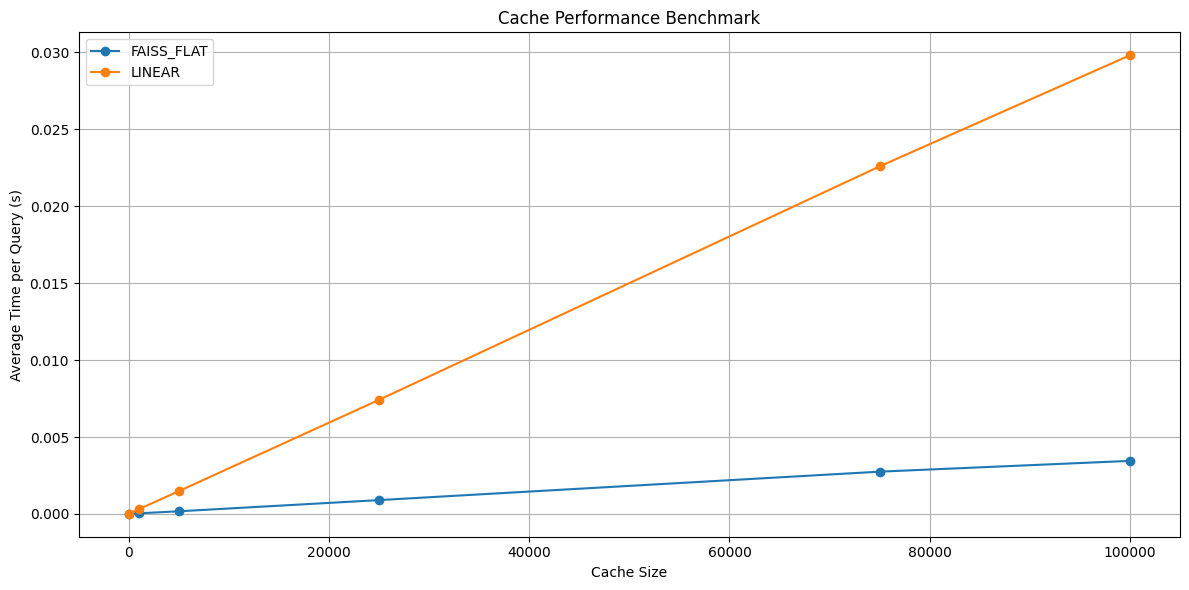

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from BaseCache import BaseSimilarityCache

# Config
DIMS = 512
CACHE_SIZES = [10, 1000, 5000, 25000, 75000, 100000]
N_QUERIES = 100

def simulate_clip_embeddings(n: int) -> np.ndarray:
    vecs = np.random.randn(n, DIMS).astype(np.float32)
    return vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

def benchmark_cache(backend: str):
    avg_times = []
    for size in CACHE_SIZES:
        cache = BaseSimilarityCache(
            capacity=size,
            threshold=0.3,
            dim=DIMS,
            backend=backend  # stringa: "faiss", "linear", "annoy"
        )
        embeddings = simulate_clip_embeddings(size)
        for i in range(size):
            cache.index.add(f"vec_{i}", embeddings[i])

        queries = simulate_clip_embeddings(N_QUERIES)
        start = time.time()
        for i, emb in enumerate(queries):
            cache.query(f"query_{i}", emb)
        end = time.time()

        avg = (end - start) / N_QUERIES
        avg_times.append(avg)
        print(f"{backend.upper()} | Cache: {size} | Time/query: {avg:.6f}s")
    return avg_times

# Esegui i benchmark per i vari backend
backends = ['faiss_flat', 'linear']

results = {}
for backend in backends:
    print(f"\nBenchmarking {backend.upper()} backend...")
    results[backend] = benchmark_cache(backend)
# Plot results
plt.figure(figsize=(12, 6))
for backend, times in results.items():
    plt.plot(CACHE_SIZES, times, marker='o', label=backend.upper())
plt.xscale('linear')
plt.xlabel('Cache Size')
plt.ylabel('Average Time per Query (s)')
plt.title('Cache Performance Benchmark')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()